# Bike Data Getting in Touch with the Data

In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

import dask.dataframe as dd

import seaborn as sns

import geopandas as gpd

import requests

In [2]:
sns.set_style("dark")

## Capital Bike Share

### Data Loading

In [3]:
cbs = dd.read_csv("data/capital_bike_share/2020*").compute()

cbs.columns = [
    "duration",
    "start_date",
    "end_date",
    "start_station_number",
    "start_station",
    "end_station_number",
    "end_station",
    "bike_number",
    "member_type"
]

DATETIME_FORMAT = "%Y-%m-%d %H:%M:%S"
for datetime_col in ["start_date", "end_date"]:
    cbs[datetime_col] = pd.to_datetime(cbs[datetime_col], format=DATETIME_FORMAT)

The available columns are of three kinds:
    
* time columns `duration` (in seconds), `start_date`, `end_date`
* location columns `start_station`, `end_station`
* bike and user properties: `biked_number`, `member_type`

In [4]:
cbs.head()

duration          start_date            end_date  start_station_number  \
0       506 2020-01-01 00:00:59 2020-01-01 00:09:26                 31623   
1      1050 2020-01-01 00:01:16 2020-01-01 00:18:47                 31613   
2      1687 2020-01-01 00:02:42 2020-01-01 00:30:50                 31218   
3       182 2020-01-01 00:02:44 2020-01-01 00:05:47                 31627   
4      1002 2020-01-01 00:06:12 2020-01-01 00:22:54                 31247   

                                       start_station  end_station_number  \
0                    Columbus Circle / Union Station               31658   
1  Eastern Market Metro / Pennsylvania Ave & 7th ...               31606   
2                     L'Enfant Plaza / 7th & C St SW               31271   
3                                      3rd & M St NE               31508   
4                          Jefferson Dr & 14th St SW               31274   

                           end_station bike_number member_type  
0                  Rosedale Rec Center      W22189      Member  
1        Potomac & Pennsylvania Ave SE      W21067      Member  
2     Constitution Ave & 2nd St NW/DOL      W24359      Member  
3  Gallaudet / 8th St & Florida Ave NE      W23334      Member  
4                       10th & G St NW      W23441      Member

Finally, the dimensions of the data:

In [5]:
cbs.shape

(537400, 9)

### First overview

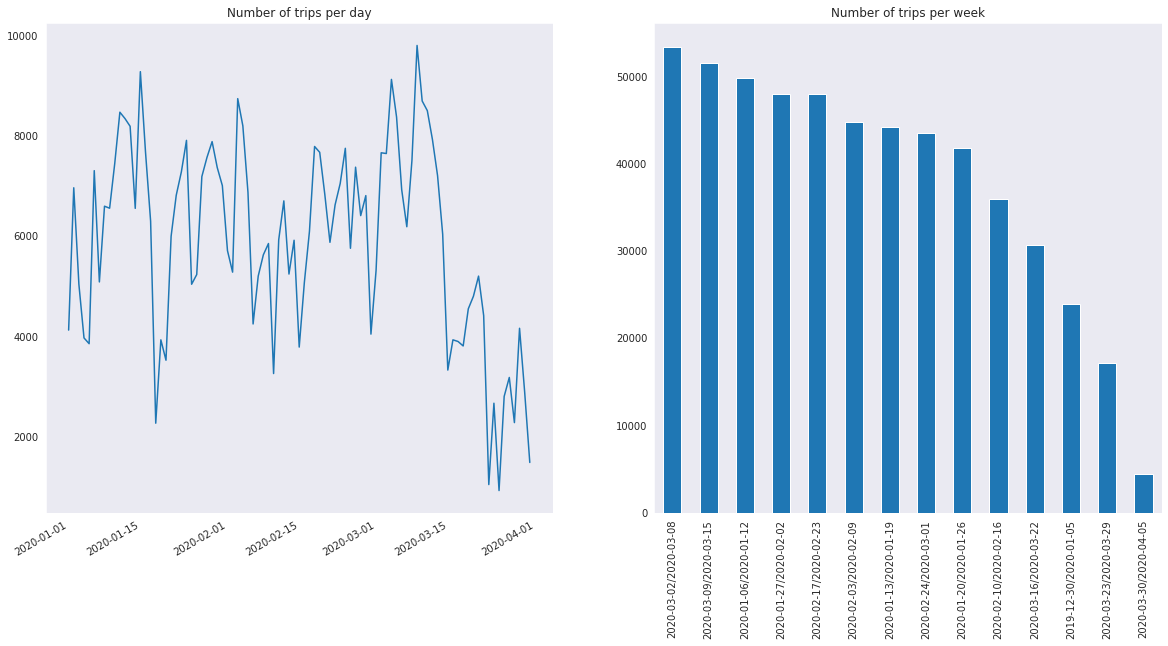

In [6]:
fig, axs = plt.subplots(ncols=2,
                       figsize=(20, 10))

cbs["start_date"].dt.normalize().value_counts().plot.line(title="Number of trips per day", ax=axs[0])

cbs["start_date"].dt.to_period("w").value_counts().plot.bar(title="Number of trips per week", ax=axs[1])

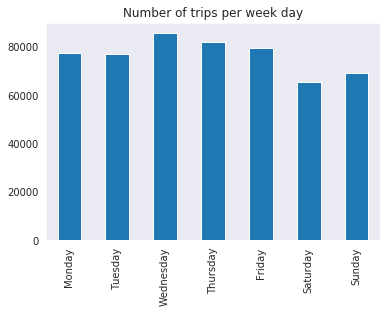

In [7]:
(cbs["start_date"]
 .dt.day_name()
 .value_counts(sort=False)
 [["Monday",
   "Tuesday",
   "Wednesday",
   "Thursday",
   "Friday",
   "Saturday",
   "Sunday"]]
 .plot.bar(title="Number of trips per week day"))

The service is more than 90% used by members:

In [8]:
cbs["member_type"].value_counts(normalize=True).to_frame()

member_type
Member     0.929432
Casual     0.070568

Let's plot the distribution of the number of trips per station (here only the 20th first stations ordered by the sum of the in/out trips)

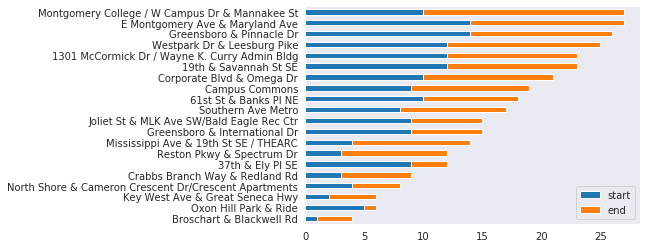

In [9]:
cbs_flow = (cbs[["start_station", "end_station"]]
            .apply(lambda d: d.value_counts(), axis=0)
            .rename(columns={"start_station": "start", "end_station": "end"}))

cbs_flow["sum"] = cbs_flow.sum(axis=1)

cbs_flow.sort_values("sum").head(20)[["start", "end"]].plot.barh(stacked=True)

Let's get a look at the duration:

In [10]:
cbs["duration"].describe(np.linspace(0, 1, 11)).to_frame().T

count        mean          std   min    0%    10%    20%    30%  \
duration  537400.0  917.590141  1902.089053  60.0  60.0  235.0  324.0  411.0   

            40%    50%    60%    70%     80%     90%     100%      max  
duration  506.0  615.0  747.0  916.0  1161.0  1574.0  86202.0  86202.0

### GBFS (real time data)

In [11]:
gbfs_capital_bike_share_url = "https://gbfs.capitalbikeshare.com/gbfs/gbfs.json"

gbfs_json = requests.get(gbfs_capital_bike_share_url).json()

What is the last time this GBFS has been updated ?

In [12]:
pd.to_datetime(gbfs_json["last_updated"], unit="s")

Timestamp('2020-05-03 20:00:45')

There is three languages and feeds for each of them. We select the english ones:

In [13]:
gbfs_en_feeds = gbfs_json["data"]["en"]["feeds"]

pd.DataFrame(gbfs_en_feeds)

name                                                url
0   system_information  https://gbfs.capitalbikeshare.com/gbfs/en/syst...
1  station_information  https://gbfs.capitalbikeshare.com/gbfs/en/stat...
2       station_status  https://gbfs.capitalbikeshare.com/gbfs/en/stat...
3     free_bike_status  https://gbfs.capitalbikeshare.com/gbfs/en/free...
4         system_hours  https://gbfs.capitalbikeshare.com/gbfs/en/syst...
5      system_calendar  https://gbfs.capitalbikeshare.com/gbfs/en/syst...
6       system_regions  https://gbfs.capitalbikeshare.com/gbfs/en/syst...
7        system_alerts  https://gbfs.capitalbikeshare.com/gbfs/en/syst...

In [14]:
data = { name: requests.get(url).json() for name, url in (d.values() for d in gbfs_en_feeds)}

system_information = pd.Series(data["system_information"]["data"])

station_information = pd.DataFrame(data["station_information"]["data"]["stations"])

station_status = pd.DataFrame(data["station_status"]["data"]["stations"])

Right now the interesting part is the station location and name:

In [15]:
station_information.head()

eightd_station_services  has_kiosk        lat  \
0                      []       True  38.858971   
1                      []       True  38.857250   
2                      []       True  38.856425   
3                      []       True  38.860170   
4                      []       True  38.857866   

                                         rental_uris  \
0  {'android': 'https://dc.lft.to/lastmile_qr_sca...   
1  {'android': 'https://dc.lft.to/lastmile_qr_sca...   
2  {'android': 'https://dc.lft.to/lastmile_qr_sca...   
3  {'android': 'https://dc.lft.to/lastmile_qr_sca...   
4  {'android': 'https://dc.lft.to/lastmile_qr_sca...   

                            external_id  eightd_has_key_dispenser region_id  \
0  082469cc-1f3f-11e7-bf6b-3863bb334450                     False        41   
1  08246b69-1f3f-11e7-bf6b-3863bb334450                     False        41   
2  08246c35-1f3f-11e7-bf6b-3863bb334450                     False        41   
3  08246cd5-1f3f-11e7-bf6b-3863bb334450                     False        41   
4  08246d68-1f3f-11e7-bf6b-3863bb334450                     False        41   

  short_name station_id station_type  capacity  \
0      31000          1      classic        15   
1      31001          2      classic        11   
2      31002          3      classic        17   
3      31003          4      classic        11   
4      31004          5      classic        11   

                                           name     rental_methods        lon  \
0                           Eads St & 15th St S  [KEY, CREDITCARD] -77.053230   
1                           18th St & S Eads St  [KEY, CREDITCARD] -77.053320   
2                        Crystal Dr & 20th St S  [KEY, CREDITCARD] -77.049232   
3                        Crystal Dr & 15th St S  [KEY, CREDITCARD] -77.049593   
4  Aurora Hills Cmty Ctr / 18th St & S Hayes St  [KEY, CREDITCARD] -77.059490   

   electric_bike_surcharge_waiver  
0                           False  
1                           False  
2                           False  
3                           False  
4                           False

Also let's count the stations we got here:

In [16]:
station_information.shape

(591, 15)

Now we need to checks the GBFS data are in sync with the historic trips.

Below the station names that are in historic trips but not in the GBFS:

In [17]:
cbs_only = set(cbs["start_station"]) - set(station_information["name"])
cbs_only

{'14th & R St NW', '22nd & H  NW (disabled)'}

Are those stations strange or temporary ?

Let's have a better idea of their distribution:

In [18]:
cbs[["start_station", "end_station"]].apply(lambda s: s[s.isin(cbs_only)].value_counts(), axis=0)

start_station  end_station
14th & R St NW                     962         1036
22nd & H  NW (disabled)            278          313

The trips coming from/to those two stations are only from January, that means maybe the docks have been disabled.

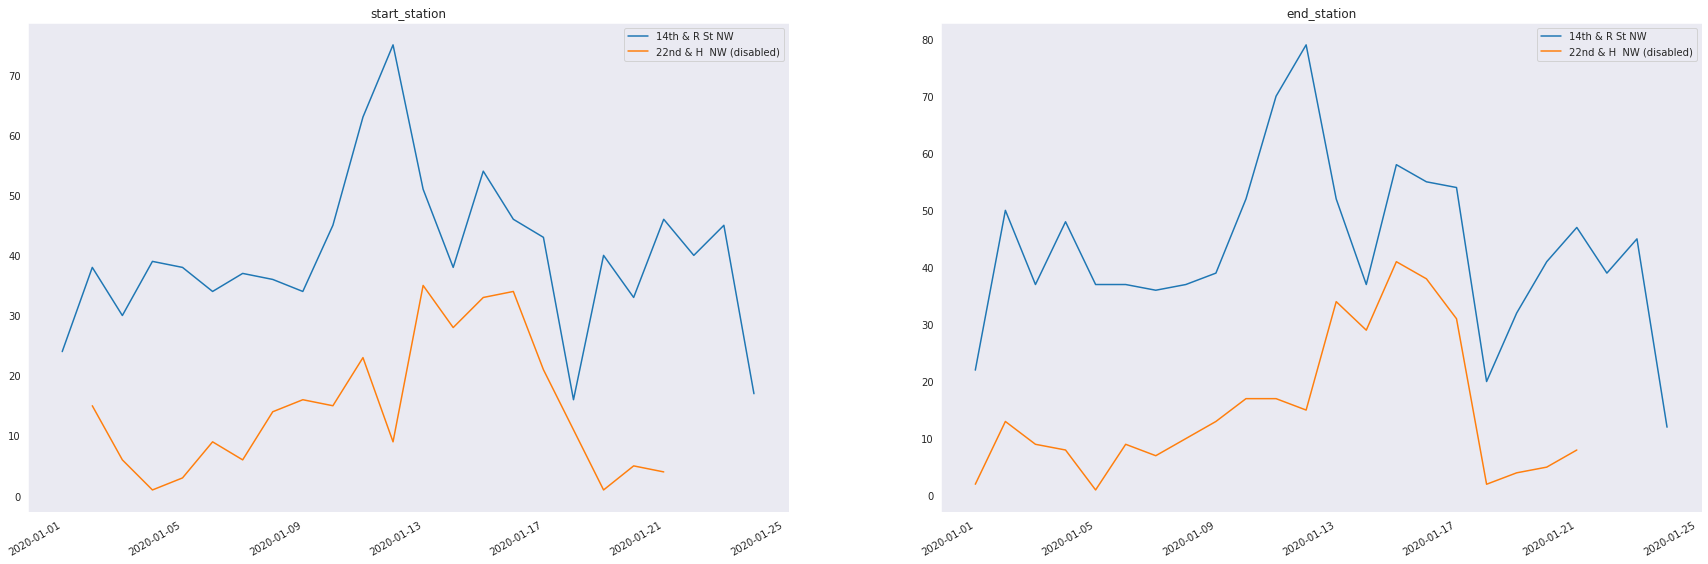

In [19]:
fig, axs = plt.subplots(ncols=2, figsize=(30, 10))

(cbs.loc[cbs["start_station"] == "14th & R St NW", "start_date"]
 .dt.normalize()
 .value_counts()
 .rename("14th & R St NW")
 .plot.line(legend=True, ax=axs[0]))
(cbs.loc[cbs["start_station"] == "22nd & H  NW (disabled)", "start_date"]
 .dt.normalize()
 .value_counts()
 .rename("22nd & H  NW (disabled)")
 .plot.line(legend=True, ax=axs[0]))

axs[0].set_title("start_station")

(cbs.loc[cbs["end_station"] == "14th & R St NW", "start_date"]
 .dt.normalize()
 .value_counts()
 .rename("14th & R St NW")
 .plot.line(legend=True, ax=axs[1]))
(cbs.loc[cbs["end_station"] == "22nd & H  NW (disabled)", "start_date"]
 .dt.normalize()
 .value_counts()
 .rename("22nd & H  NW (disabled)")
 .plot.line(legend=True, ax=axs[1]))

axs[1].set_title("end_station");

Two stations out of more than 500 is actually quite a low number and we can deal with that with not uptodate data.

In [20]:
cbs["start_station"].nunique()

583

Finally, what are the number id of those stations:

In [21]:
cbs.loc[cbs["start_station"].isin(cbs_only), ["start_station", "start_station_number"]].drop_duplicates()

start_station  start_station_number
22             14th & R St NW                 31202
4854  22nd & H  NW (disabled)                     0

### GIS Data

We need to query the GIS server of Washington DC for GeoJSON data.

In [22]:
cbs_locations_url = "https://maps2.dcgis.dc.gov/dcgis/rest/services/DCGIS_DATA/Transportation_WebMercator/MapServer/5/query?where=1%3D1&outFields=*&outSR=4326&f=json"

cbs_locations = gpd.read_file(cbs_locations_url)

cbs_locations.head(5)

OBJECTID  ID                                       ADDRESS  \
0  314250754   1                           Eads St & 15th St S   
1  314250755   2                           18th St & S Eads St   
2  314250756   3                        Crystal Dr & 20th St S   
3  314250757   4                        Crystal Dr & 15th St S   
4  314250758   5  Aurora Hills Cmty Ctr / 18th St & S Hayes St   

  TERMINAL_NUMBER   LATITUDE  LONGITUDE INSTALLED LOCKED INSTALL_DATE  \
0           31000  38.858971 -77.053230       YES     NO         None   
1           31001  38.857250 -77.053320       YES     NO         None   
2           31002  38.856425 -77.049232       YES     NO         None   
3           31003  38.860170 -77.049593       YES     NO         None   
4           31004  38.857866 -77.059490       YES     NO         None   

  REMOVAL_DATE TEMPORARY_INSTALL  NUMBER_OF_BIKES  NUMBER_OF_EMPTY_DOCKS  \
0         None                NO               10                      5   
1         None                NO                0                     11   
2         None                NO                6                     10   
3         None                NO               10                      1   
4         None                NO                4                      6   

               X              Y SE_ANNO_CAD_DATA OWNER  \
0  395379.968612  132352.116903             None  None   
1  395372.045590  132161.078081             None  None   
2  395726.817575  132069.297863             None  None   
3  395695.709759  132485.036787             None  None   
4  394836.559865  132229.789395             None  None   

                     geometry  
0  POINT (-77.05323 38.85898)  
1  POINT (-77.05332 38.85726)  
2  POINT (-77.04923 38.85643)  
3  POINT (-77.04960 38.86018)  
4  POINT (-77.05949 38.85787)

Let's see the dimension of the data:

In [23]:
cbs_locations.shape

(591, 18)

It seems there is no new stations, but the data are a little bit different even though if some of them are full of missing values or with degenerated:

In [24]:
cbs_locations.nunique().sort_values()

INSTALL_DATE               0
SE_ANNO_CAD_DATA           0
REMOVAL_DATE               0
INSTALLED                  1
LOCKED                     1
OWNER                      1
TEMPORARY_INSTALL          1
NUMBER_OF_EMPTY_DOCKS     27
NUMBER_OF_BIKES           30
LONGITUDE                588
LATITUDE                 590
Y                        591
X                        591
OBJECTID                 591
ADDRESS                  591
ID                       591
TERMINAL_NUMBER          591
geometry                 591
dtype: int64

As a first approach to get a result, we are going to ignore the stations without name.